# <span style='color:red'>Project 2.  Due October 23</span>

### In this project we develop a first-order algorithm to construct a portfolio using intraday data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize

##### We will have data involving $n$ assets, and use the first $T$ days of the data to compute the portfolio.
##### The computation will produce a weight $x_i$ for each asset $i = 1,...,n$, which could be long or short.
##### We assume that on each day, a position is taken at the open, and closed at noon.  So we define:
$$ p^o_{j,t} = \ \text{price of asset $j$ on day $t$ at the open}$$
$$ p^1_{j,t} = \ \text{price of asset $j$ on day $t$ at noon}$$
$$ r_{j,t} =  \ \frac{p^1_{j,t} - p^o_{j,t}}{p^o_{j,t}} = \ \text{return earned by asset $j$ on day $t$.}$$
$$ \bar r_j = \ \frac{1}{T} \sum_{t = 1}^T r_{j,t} = \ \text{average return earned by asset $j$.}$$

#### The optimization problem to solve depends on two parameters: $\theta \ge 0$ and $\pi > 0 0$.
####
$$ \text{minimize} \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)^{1/\pi}$$
#### 
#### There are no constraints on the quantities $x_j$.
#### The first sum is minus the average return earned by the portfolio.  In the second sum, the quantity inside the square brackets is the excess return earned by the portfolio on day $t$, magnified by the power $\pi$.  The quantity $\theta$ is a risk aversion parameter.
 

### <span style='color:red'> Task 1. Develop a first-order method to address this computational problem.</span>
#### 
#### Your method should work with values of $T$ at least $100$. Use the data we provide for AMZN, NFLX, TSLA, i.e., $n = 3$. 
###
#### Make sure your code works with $\pi = 0.5, 2, 4, 6$, and $\theta = 0.1, 10, 1000, 10^5, 10^6$.

Denote the objective function as  $F(x)$. We will take the gradient of $ F(x) $ with respect to the vector $ x $. The gradient will be a vector of partial derivatives, where each element $ k $ is the partial derivative of $ F(x) $ with respect to $ x_k $.

$$ F(x) = \left(-\sum_{j = 1}^n \bar r_j x_j\right) + \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)^{1/\pi} $$

Let's take the derivative piece by piece.

1. **Derivative of the first term (g)**:
$$ \frac{dg}{dx_k} \left(-\sum_{j = 1}^n \bar r_j x_j\right) = -\bar r_k $$

2. **Derivative of the second term (h)**:
$$ \frac{dh}{dx_k} = \theta \cdot \frac{1}{\pi} \left[\frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right]^{(1/\pi)-1} \cdot \frac{1}{T} \sum_{t = 1}^{T} \pi \left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^{\pi-1} \cdot (r_{k,t} -  \bar r_k) $$

3. **Sum and simplification of the derivatives**:

$$ \frac{\partial F(x)}{\partial x_k} = -\bar r_k + \theta \cdot \left[\frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right]^{(1/\pi)-1} \cdot \frac{1}{T} \sum_{t = 1}^{T} \left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^{\pi-1} \cdot (r_{k,t} -  \bar r_k) $$

In [93]:
def func(x, r_bar, r_diff, theta, pi, T):
    return -np.dot(r_bar, x) + (theta*(1/T)**(1/pi)) * ( np.linalg.norm(r_diff @ x, pi) )

def grad(x, r_bar, r_diff, theta, pi, T):
    r_diff_at_x = r_diff @ x
    temp = (theta*(1/T)**(1/pi - 1)) * np.linalg.norm(r_diff_at_x, pi)**(1-pi) * (1/T)*( (r_diff_at_x**(pi-1)).T @ r_diff )
    return -r_bar + temp

In [69]:
# print('VECTORZ:')
# print( optimize.minimize(fun=func, x0=np.array([0,0,0]), args=(r_bar, r_diff, 1e1, 10, 100), method='SLSQP') )

# # print('GUIDO:')
# # print( optimize.minimize(fun=objective_function, x0=np.array([0,0,0]), args=(train.values, r_bar, 1e1, 10, 100), method='SLSQP') )

In [26]:
# def compute_gradient(x, r, r_bar, theta, pi, T):
#     n = len(x)
#     gradient = np.zeros(n)
    
#     # Compute u
#     u = (1/T) * np.sum([(np.sum([(r[t, j] - r_bar[j]) * x[j] for j in range(n)]))**pi for t in range(T)])
    
#     for k in range(n):
#         term1 = -r_bar[k]
#         term2 = theta * (1/pi) * u**((1/pi)-1) * (1/T) * np.sum([pi * (np.sum([(r[t, j] - r_bar[j]) * x[j] for j in range(n)]))**(pi-1) * (r[t, k] - r_bar[k]) for t in range(T)])
#         gradient[k] = term1 + term2
        
#     return gradient

In [94]:
df = list()
for ticker in ['AMZN', 'NFLX', 'TSLA']:
    df.append( pd.read_csv(f'./data/{ticker}_processed.csv', index_col=0) )

df = pd.concat(df, axis=1).dropna(how='any')

train = df[:100]
test = df[100:]

r_bar = train.mean(axis=0).values
r_diff = train.subtract(r_bar).values

In [58]:
# def objective_function(x, r, r_bar, theta, pi, T):
        
#     # Compute the first term
#     term1 = -np.sum(r_bar * x)
    
#     # Compute the inner sum for the second term
#     inner_sum = np.array([(np.sum((r[t, :] - r_bar) * x))**pi for t in range(T)])
    
#     # Compute the second term
#     term2 = theta * ((1/T) * np.sum(inner_sum))**(1/pi)
    
#     # Compute the value of F(x)
#     F_x = term1 + term2
    
#     return F_x

# def compute_gradient(x, r, r_bar, theta, pi, T):
#     n = len(x)
#     gradient = np.zeros(n)
    
#     # Compute u
#     u = (1/T) * np.sum([(np.sum([(r[t, j] - r_bar[j]) * x[j] for j in range(n)]))**pi for t in range(T)])
    
#     for k in range(n):
#         term1 = -r_bar[k]
#         term2 = theta * (1/pi) * u**((1/pi)-1) * (1/T) * np.sum([pi * (np.sum([(r[t, j] - r_bar[j]) * x[j] for j in range(n)]))**(pi-1) * (r[t, k] - r_bar[k]) for t in range(T)])
#         gradient[k] = term1 + term2
        
#     return gradient

# def guido_gradient(r, r_bar, initial_x, alpha, theta, pi, T, max_iterations=1000, tolerance=1e-6):
#     x = initial_x
#     hist = dict()
#     converged = False
#     for k in range(max_iterations):
#         gradient = compute_gradient(x, r, r_bar, theta, pi, T)
#         hist[k] = objective_function(x, r, r_bar, theta, pi, T)
#         # Update rule
#         x_new = x - alpha * gradient
        
#         cos_beta = np.dot(x, x_new) / (np.linalg.norm(x) * np.linalg.norm(x_new)) # beta is angle between x and x_new
#         if np.abs( cos_beta - 1 ) < tolerance:
#         # if np.linalg.norm(x_new - x) < tolerance:
#             converged = True
#             break
        
#         x = x_new
        
#     return converged, x, hist

In [98]:
def gradient_descent(r_bar, r_diff, theta, pi, x_0, alpha, beta, max_iter=1000, tolerance=1e-8):
    converged = False
    T = r_diff.shape[0]
    x = y = x_0
    f = func(x=x, r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, T=T)
    hist = {0: f}
    for t in range(max_iter):
        grad_ = grad(x=x, r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, T=T)
        grad_ /= np.linalg.norm(grad_)

        # update rule
        # y_new = x - alpha * grad_        
        # x_new = y_new + beta*(y_new - y)
        y = beta*y + (1-beta)*grad_
        x = x - alpha*y

        # convergence check
        # x_new /= np.linalg.norm(x_new)
        # cos_beta = np.dot(x, x_new) / (np.linalg.norm(x) * np.linalg.norm(x_new)) # beta is angle between x and x_new
        # if np.abs( cos_beta - 1 ) < tolerance and 
        # if np.linalg.norm(x - x_new) < tolerance:
        f_new = func(x=x, r_bar=r_bar, r_diff=r_diff, theta=theta, pi=pi, T=T)
        hist[t+1] = f_new
        if f - f_new < tolerance:
            converged = True
            break
        
        f = f_new
        
    return converged, x, hist

In [10]:
# # import pandas as pd
# # import numpy as np
# # from tqdm import tqdm

# # Load processed returns
# tickers = ['AMZN', 'NFLX', 'TSLA']

# # Load processed returns as DataFrames
# returns_df = {}
# for ticker in tickers:
#     returns_df[ticker] = pd.read_csv(f'./data/{ticker}_processed.csv', index_col=0)

# # Find the common dates where all tickers have returns
# common_dates = set(returns_df[tickers[0]].index)
# for ticker in tickers[1:]:
#     common_dates.intersection_update(set(returns_df[ticker].index))

# # Filter the returns for each ticker based on the common dates
# for ticker in tickers:
#     returns_df[ticker] = returns_df[ticker].loc[common_dates]

# # Convert filtered returns to matrix form
# r = np.column_stack([returns_df[ticker]['Returns'].values for ticker in tickers])

In [ ]:
# # Run Gradient Descent for each combination of pi and theta
# results = {}
# for pi in pis:
#     for theta in thetas:
#         x_optimal = gradient_descent(train, r_bar, initial_x, alpha, theta, pi, train.shape[0])
#         results[(pi, theta)] = x_optimal

#print(results)

In [29]:
# np.random.seed(1)
# x_0 = np.random.uniform(-100, 100, 3)
# # x_0 = np.ones(3)
# x_0 /= np.linalg.norm(x_0)

In [6]:
# # # Compute average returns
# # r_bar = np.mean(r_train, axis=0)
# from tqdm.notebook import tqdm
# # Gradient Descent parameters
# alpha = 1e-1  # step size, might need adjustment
# pis = [0.5, 2, 4, 6]
# thetas = [0.1, 10, 1000, 10**5, 10**6]

# container = list()
# pbar = tqdm(len(pis)*len(thetas), leave=True)
# for pi in pis:
#     for theta in thetas:
#         converged, x, hist = gradient_descent(r_bar, r_diff, theta=theta, pi=pi, x_0=x_0, alpha=alpha, max_iter=1000, tolerance=1e-6)
#         container.append((pi, theta, converged, x, hist))
#         pbar.update()
# pbar.close()

0.0008734542075995079
[-0.05176295  0.08413733 -0.00448451]


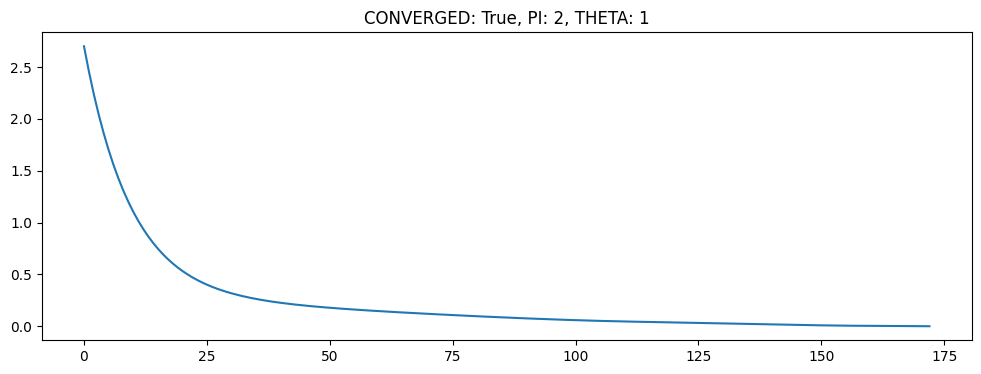

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

x_0 = np.array([69]*3)
# i = 18
# hist = container[i][-1]
# pi, theta = container[i][0], container[i][1]
pi = 2
theta = 1
alpha = 1e-1
beta = 0.9
# converged, x, hist = guido_gradient(train.values, r_bar, x_0, alpha, theta, pi, T=train.shape[0], max_iterations=1000, tolerance=1e-6)
converged, x, hist = gradient_descent(r_bar, r_diff, theta, pi, x_0, alpha, beta, max_iter=int(10000), tolerance=1e-10)
print(list(hist.values())[-1])
print(x)
sns.lineplot(x=list(hist.keys()), y=list(hist.values()), ax=ax)
plt.title(f'CONVERGED: {converged}, PI: {pi}, THETA: {theta}')

plt.show()

### <span style='color:red'>Task 2: Benchmark your portfolio on the remaining days</span>
#### On each of the remaining days, we proceed as follows.  Denote by $x^*$ your portfolio. At the market open we invest $10^9 x^*_j$ on each asset $j$, and we close the position (by) noon.  You need to use the asset's price to compute the number of shares that you invest in, whether long or short. So the total you invest equals $$ \sum_{j = 1}^n 10^9 |x^*_j|.$$
#### Report the average return earned by your portfolio.

In [147]:
(test@x).mean()

-0.00014828105909692657

In [148]:
# # Assuming x_star is the optimal portfolio obtained from the Gradient Descent
# chosen_pi = 2
# chosen_theta = 100000
# x_star = results[(chosen_pi, chosen_theta)]  # replace chosen_pi and chosen_theta with the values you used



# # Compute the total investment and returns for each day
# total_investments = []
# total_returns = []
# for t in range(len(remaining_data[tickers[0]])):
#     daily_investment = 0
#     daily_return = 0
#     for j, ticker in enumerate(tickers):
#         open_price = remaining_data[ticker].iloc[t]['Open']
#         noon_price = remaining_data[ticker].iloc[t]['Close']
        
#         # Number of shares for asset j
#         shares = (10**9 * x_star[j]) / open_price
        
#         # Total investment for asset j
#         daily_investment += abs(10**9 * x_star[j])
        
#         # Return for asset j
#         asset_return = (noon_price - open_price) * shares
#         daily_return += asset_return
        
#     total_investments.append(daily_investment)
#     total_returns.append(daily_return)

# # Compute the average return
# average_return = np.mean(total_returns) / np.mean(total_investments)

# print(f"Average return earned by the portfolio: {average_return:.2%}")


In [8]:
def compute_portfolio_return(x_star, r, po, p1):
    n = len(x_star)
    daily_returns = []
    
    for t in range(len(r)):
        shares = [10**9 * x_star[j] / po[t, j] for j in range(n)]
        daily_return = sum([shares[j] * (p1[t, j] - po[t, j]) for j in range(n)])
        daily_returns.append(daily_return)
    
    return np.mean(daily_returns)

# Split the data into training and testing sets
T_train = T  # Number of training days
po_train = po[:T_train]  # Prices at open for training days
p1_train = p1[:T_train]  # Prices at noon for training days

po_test = po[T_train:]  # Prices at open for testing days
p1_test = p1[T_train:]  # Prices at noon for testing days

# Compute the average return for the portfolio on the testing days
average_return = compute_portfolio_return(x_optimal, r[T_train:], po_test, p1_test)
print(f"Average return on the remaining days: {average_return}")


NameError: name 'T' is not defined